<a href="https://colab.research.google.com/github/krrish9973/Msc-Thesis/blob/main/Mental_Health_Assesment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mental Health Assessment Using Multimodal AI

### System & Hardware Environment Check for Reproducible Experiments
--------------------------------------------------------------------------

Purpose
-------
This script collects and displays runtime system information to verify the
computational environment before running machine learning or deep learning
experiments.

It helps ensure:
- Reproducibility of results
- Hardware compatibility
- GPU availability for acceleration
- Sufficient memory and disk resources

Information Collected
---------------------
1. Operating System details
2. CPU processor and core count
3. Total system RAM
4. GPU status and specifications using nvidia-smi (for Colab/local CUDA setups)
5. Disk storage usage

---



Author: <b>Krishna Prasad Joshi</b><br>
Date: 15.01.2026


In [ ]:
import platform
import psutil
import os

print("=" * 50)
print("SYSTEM INFORMATION")
print("=" * 50)

print(f"OS           : {platform.system()} {platform.release()}")
print(f"Processor    : {platform.processor()}")
print(f"CPU Cores    : {os.cpu_count()}")

# RAM
mem = psutil.virtual_memory()
print(f"Total RAM    : {mem.total / (1024**3):.2f} GB")

print("\n" + "=" * 50)
print("GPU INFORMATION")
print("=" * 50)

try:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if "failed" in gpu_info.lower():
        print("No GPU detected. Enable GPU in runtime settings.")
    else:
        print(gpu_info)
except:
    print("nvidia-smi not available.")

print("\n" + "=" * 50)
print("DISK INFORMATION")
print("=" * 50)

usage = psutil.disk_usage('/')
print(f"Total Disk   : {usage.total / (1024**3):.2f} GB")
print(f"Used         : {usage.used / (1024**3):.2f} GB")
print(f"Free         : {usage.free / (1024**3):.2f} GB")

SYSTEM INFORMATION
OS           : Linux 6.6.105+
Processor    : x86_64
CPU Cores    : 12
Total RAM    : 83.47 GB

GPU INFORMATION
Sat Feb 14 09:35:40 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             51W /  400W |       0MiB /  40960MiB |      0%      Default |
|         

## Pre-Modeling Clinical Data Validation and Leakage Control

In [ ]:
import pandas as pd


def perform_clinical_audit(data):
    """
    Perform a structured clinical audit of the DAIC-WOZ dataset.

    Parameters
    ----------
    data : pandas.DataFrame
        Input dataframe containing:
        - PHQ8_Score
        - PHQ8_Binary
        - other clinical or multimodal features

    Prints
    ------
    • Participant statistics
    • Score range
    • Class distribution (counts + percentages)
    • Potential leakage columns
    • Top missing value summary

    Notes
    -----
    This function is intended for pre-modeling validation and should be
    executed before any training pipeline to ensure clean, leakage-free data.
    """

    print("=" * 60)
    print("DAIC-WOZ CLINICAL DATA AUDIT REPORT")
    print("=" * 60)

    print(f"Total Participants Analyzed : {len(data)}")
    print(f"PHQ-8 Score Range           : {data['PHQ8_Score'].min()} to {data['PHQ8_Score'].max()}")

    # Distribution Analysis
    counts = data['PHQ8_Binary'].value_counts().to_dict()
    dist = data['PHQ8_Binary'].value_counts(normalize=True) * 100

    print(f"Binary Distribution (0/1)   : {counts}")
    print(f"Class Percentage            : 0: {dist[0]:.2f}%, 1: {dist[1]:.2f}%")

    # Feature Leakage Identification
    leakage_cols = [
        c for c in data.columns
        if c.startswith('PHQ8_') and c not in ['PHQ8_Score', 'PHQ8_Binary']
    ]

    print(f"\n[LEAKAGE CONTROL] Identified {len(leakage_cols)} sub-items for exclusion:")
    print(f"Items: {leakage_cols}")

    # Null Value Identification
    print(f"\n[INTEGRITY] Null Value Audit (Top 5):")
    print(data.isnull().sum().sort_values(ascending=False).head(5))

    print("=" * 60)


# -------------------------------------------------------
# Load the AVEC 2017 Training Split
# (Used for model development and training)
# -------------------------------------------------------
perform_clinical_audit(pd.read_csv("train_split_Depression_AVEC2017.csv"))


# -------------------------------------------------------
# Load the AVEC 2017 Dev/Testing Split
# (Used only for evaluation after training)
# -------------------------------------------------------
perform_clinical_audit(pd.read_csv("dev_split_Depression_AVEC2017.csv"))

DAIC-WOZ CLINICAL DATA AUDIT REPORT
Total Participants Analyzed : 107
PHQ-8 Score Range           : 0 to 20
Binary Distribution (0/1)   : {0: 77, 1: 30}
Class Percentage            : 0: 71.96%, 1: 28.04%

[LEAKAGE CONTROL] Identified 8 sub-items for exclusion:
Items: ['PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired', 'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving']

[INTEGRITY] Null Value Audit (Top 5):
PHQ8_Sleep        1
Participant_ID    0
PHQ8_Score        0
PHQ8_Binary       0
Gender            0
dtype: int64
DAIC-WOZ CLINICAL DATA AUDIT REPORT
Total Participants Analyzed : 35
PHQ-8 Score Range           : 0 to 23
Binary Distribution (0/1)   : {0: 23, 1: 12}
Class Percentage            : 0: 65.71%, 1: 34.29%

[LEAKAGE CONTROL] Identified 8 sub-items for exclusion:
Items: ['PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired', 'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving']

[INTEGRITY] Null Value Audit (Top 5):
Pa

## Multimodal Depression Detection with Ablation Study (DAIC-WOZ)

#### Text, Eye Gaze, Facial Action Units, and Clinical Feature Fusion
Loads the prepared master feature dataset, aligns it with official train/dev splits, constructs modality-specific feature matrices (text, eye, face, clinical), and trains classifiers to evaluate depression prediction performance through systematic multimodal fusion and ablation studies.

In [ ]:
# Import necessary Libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

class DepressionAnalyzer:
    """
        DepressionAnalyzer

        This class implements the complete training and evaluation pipeline for
        multimodal depression detection.

        It loads the prepared master feature dataset, separates different
        modalities (text, eye gaze, facial features, and clinical scores),
        applies the required preprocessing (TF-IDF and scaling), and trains
        machine learning models.

        It also supports ablation experiments to compare:
        - behavioral features only (leakage-free)
        - behavioral + clinical (PHQ-8) features

        The goal is to measure how much each modality contributes to prediction
        performance.

    """

    def __init__(self, c_val=0.1):
        """
        Initialize the analyzer with model hyperparameters.

        Args:
            c_val (float): Regularization strength. Lower values = stronger penalty.
        """
        self.c_val = c_val
        self.tfidf = TfidfVectorizer(max_features=2000, stop_words="english")
        self.bio_scaler = StandardScaler()
        self.results = []

    def load_and_preprocess(self, feature_path, train_path, dev_path):
        """
        Loads CSV files and aligns features with clinical labels via Participant ID.
        """
        df_feat = pd.read_csv(feature_path)

        def process_split(split_path):
            df_label = pd.read_csv(split_path).rename(columns={"Participant_ID": "participant_id"})
            merged = pd.merge(df_feat, df_label, on="participant_id", how="inner")
            return merged.dropna()

        return process_split(train_path), process_split(dev_path)

    def extract_modality_matrices(self, df_train, df_dev):
        """
        Transforms raw data into specialized feature matrices.
        - Text is processed via TF-IDF.
        - Bio-features are Z-score normalized.
        - PHQ items are preserved as raw ordinal counts.
        """
        # 1. Linguistic Features
        x_tr_text = self.tfidf.fit_transform(df_train["text"])
        x_dv_text = self.tfidf.transform(df_dev["text"])

        # 2. Biometric Features (Eye Gaze + Selected Facial Action Units)
        eye_cols = ["avg_gaze_downward", "eye_contact_rate"]
        face_cols = ["AU01_r", "AU04_r", "AU12_r", "AU15_r"]

        all_bio = eye_cols + face_cols
        x_tr_bio_scaled = self.bio_scaler.fit_transform(df_train[all_bio])
        x_dv_bio_scaled = self.bio_scaler.transform(df_dev[all_bio])

        # 3. Clinical Features (The PHQ-8 'Answer Key')
        phq_items = [c for c in df_train.columns if "PHQ8_" in c and c != "PHQ8_Binary"]

        return {
            "text": (x_tr_text, x_dv_text),
            "eye": (csr_matrix(x_tr_bio_scaled[:, :len(eye_cols)]),
                    csr_matrix(x_dv_bio_scaled[:, :len(eye_cols)])),
            "face": (csr_matrix(x_tr_bio_scaled[:, len(eye_cols):]),
                     csr_matrix(x_dv_bio_scaled[:, len(eye_cols):])),
            "phq": (csr_matrix(df_train[phq_items].values),
                    csr_matrix(df_dev[phq_items].values)),
            "y": (df_train["PHQ8_Binary"].values, df_dev["PHQ8_Binary"].values)
        }

    def evaluate(self, name, x_tr, x_dv, y_tr, y_dv, phq_status):
        """Fits classifiers and tracks both Train and Test performance."""
        models = {
            "Logistic Regression": LogisticRegression(C=self.c_val, class_weight='balanced', max_iter=1000),
            "SVM (Linear)": SVC(kernel='linear', C=self.c_val, class_weight='balanced')
        }

        for m_name, clf in models.items():
            clf.fit(x_tr, y_tr)

            # Predict both sets to check for overfitting
            tr_preds = clf.predict(x_tr)
            dv_preds = clf.predict(x_dv)

            tr_acc = accuracy_score(y_tr, tr_preds)
            dv_acc = accuracy_score(y_dv, dv_preds)
            dv_f1 = classification_report(y_dv, dv_preds, output_dict=True, zero_division=0)["weighted avg"]["f1-score"]

            self.results.append({
                "Modality Mix": name,
                "PHQ?": phq_status,
                "Classifier": m_name,
                "Train Acc": round(tr_acc, 4),
                "Test Acc": round(dv_acc, 4),
                "Test F1": round(dv_f1, 4),
                "y_true": y_dv,
                "y_pred": dv_preds
            })

def run_experiments(feature_path, train_path, dev_path):
    """
    User-friendly entry point to execute the full multimodal suite.
    """
    analyzer = DepressionAnalyzer(c_val=0.1)

    # Data Loading
    df_tr, df_dv = analyzer.load_and_preprocess(feature_path, train_path, dev_path)
    m = analyzer.extract_modality_matrices(df_tr, df_dv)
    y_tr, y_dv = m["y"]

    # Define Modality Stacks
    combos = [
        ("Text Only", m["text"]),
        ("Text + Eye", (hstack([m["text"][0], m["eye"][0]]), hstack([m["text"][1], m["eye"][1]]))),
        ("Text + Eye + Face", (hstack([m["text"][0], m["eye"][0], m["face"][0]]),
                               hstack([m["text"][1], m["eye"][1], m["face"][1]])))
    ]

    # Execute Ablation Study
    for name, (x_tr_base, x_dv_base) in combos:
        # Without PHQ Items (Biometric only)
        analyzer.evaluate(name, x_tr_base, x_dv_base, y_tr, y_dv, phq_status="No")

        # With PHQ Items (Clinical augmented)
        x_tr_plus = hstack([x_tr_base, m["phq"][0]])
        x_dv_plus = hstack([x_dv_base, m["phq"][1]])
        analyzer.evaluate(name, x_tr_plus, x_dv_plus, y_tr, y_dv, phq_status="Yes")

    # Final Tabular Report
    report_df = pd.DataFrame(analyzer.results)
    print("\n" + "="*85)
    print("                 DAIC-WOZ MULTIMODAL EXPERIMENT SUMMARY")
    print("="*85)
    # print(report_df.to_string(index=False))
    return report_df

In [ ]:
# To run the experiment:
report_df = run_experiments("master_dataset.csv", "train_split_Depression_AVEC2017.csv", "dev_split_Depression_AVEC2017.csv")
report_df.head(20)


                 DAIC-WOZ MULTIMODAL EXPERIMENT SUMMARY


,Modality Mix,PHQ?,Classifier,Train Acc,Test Acc,Test F1,y_true,y_pred
0,Text Only,No,Logistic Regression,0.8182,0.5312,0.5413,"[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,Text Only,No,SVM (Linear),0.2828,0.3438,0.1759,"[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,Text Only,Yes,Logistic Regression,0.9697,0.9375,0.9385,"[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, ..."
3,Text Only,Yes,SVM (Linear),0.9798,1.0000,1.0000,"[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, ..."
4,Text + Eye,No,Logistic Regression,0.8081,0.8125,0.8074,"[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, ..."
5,Text + Eye,No,SVM (Linear),0.7071,0.7188,0.6462,"[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
6,Text + Eye,Yes,Logistic Regression,0.9697,0.9375,0.9385,"[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, ..."
7,Text + Eye,Yes,SVM (Linear),0.9798,1.0000,1.0000,"[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, ..."
8,Text + Eye + Face,No,Logistic Regression,0.6465,0.6562,0.6637,"[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, ...","[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, ..."
9,Text + Eye + Face,No,SVM (Linear),0.4646,0.4688,0.4483,"[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, ..."


### Multimodal Model Evaluation and Performance Visualization

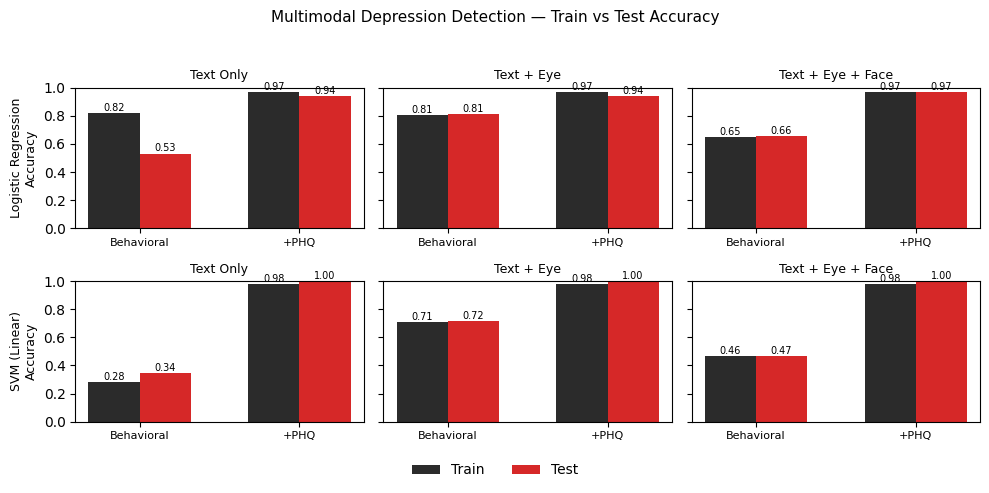

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df = report_df.copy()

modalities  = df["Modality Mix"].unique()
classifiers = df["Classifier"].unique()

# Nepal-flag inspired high contrast colors
train_color = "#2b2b2b"
test_color  = "#d62828"

fig, axes = plt.subplots(2, 3, figsize=(10, 4.8), sharey=True)

for r, clf in enumerate(classifiers):
    for c, modality in enumerate(modalities):

        ax = axes[r, c]

        sub = df[(df["Modality Mix"] == modality) & (df["Classifier"] == clf)]

        with_phq  = sub[sub["PHQ?"] == "Yes"].iloc[0]
        without_phq = sub[sub["PHQ?"] == "No"].iloc[0]

        groups = ["Behavioral", "+PHQ"]

        train_vals = [without_phq["Train Acc"], with_phq["Train Acc"]]
        test_vals  = [without_phq["Test Acc"],   with_phq["Test Acc"]]

        x = np.arange(len(groups))
        width = 0.32

        ax.bar(x - width/2, train_vals, width, color=train_color)
        ax.bar(x + width/2, test_vals,  width, color=test_color)

        ax.set_xticks(x)
        ax.set_xticklabels(groups, fontsize=8)
        ax.set_ylim(0, 1)

        ax.set_title(modality, fontsize=9)

        if c == 0:
            ax.set_ylabel(f"{clf}\nAccuracy", fontsize=9)

        # cleaner small labels
        for i, v in enumerate(train_vals):
            ax.text(i - width/2, v + 0.015, f"{v:.2f}", ha='center', fontsize=7)
        for i, v in enumerate(test_vals):
            ax.text(i + width/2, v + 0.015, f"{v:.2f}", ha='center', fontsize=7)

# legend BELOW (no overlap)
fig.legend(["Train", "Test"],
           loc="lower center",
           ncol=2,
           bbox_to_anchor=(0.5, -0.02),
           frameon=False)

plt.suptitle("Multimodal Depression Detection — Train vs Test Accuracy", fontsize=11)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # reserve space for legend

plt.show()



=========== CLINICAL METRICS REPORT ===========



,Modality,PHQ,Model,Accuracy,Precision,Recall(Sensitivity),Specificity,F1,TP,FP,FN,TN
0,Text Only,No,Logistic Regression,0.5312,0.3571,0.4545,0.5714,0.4000,5,9,6,12
1,Text Only,No,SVM (Linear),0.3438,0.3438,1.0000,0.0000,0.5116,11,21,0,0
2,Text Only,Yes,Logistic Regression,0.9375,0.8462,1.0000,0.9048,0.9167,11,2,0,19
3,Text Only,Yes,SVM (Linear),1.0000,1.0000,1.0000,1.0000,1.0000,11,0,0,21
4,Text + Eye,No,Logistic Regression,0.8125,0.7778,0.6364,0.9048,0.7000,7,2,4,19
5,Text + Eye,No,SVM (Linear),0.7188,1.0000,0.1818,1.0000,0.3077,2,0,9,21
6,Text + Eye,Yes,Logistic Regression,0.9375,0.8462,1.0000,0.9048,0.9167,11,2,0,19
7,Text + Eye,Yes,SVM (Linear),1.0000,1.0000,1.0000,1.0000,1.0000,11,0,0,21
8,Text + Eye + Face,No,Logistic Regression,0.6562,0.5000,0.6364,0.6667,0.5600,7,7,4,14
9,Text + Eye + Face,No,SVM (Linear),0.4688,0.3750,0.8182,0.2857,0.5143,9,15,2,6


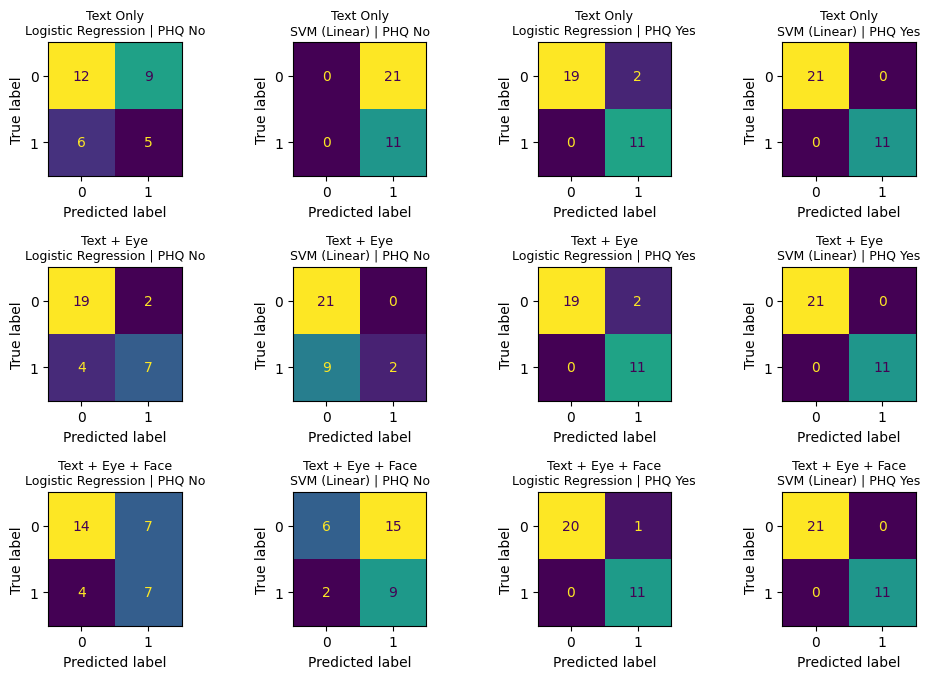

In [ ]:
# =====================================================
# METRICS + CONFUSION MATRIX
# =====================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

df = report_df.copy()

metrics_rows = []
cm_data = []

for _, row in df.iterrows():

    y_true = row["y_true"]
    y_pred = row["y_pred"]

    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spec = tn / (tn + fp) if (tn + fp) else 0

    metrics_rows.append([
        row["Modality Mix"],
        row["PHQ?"],
        row["Classifier"],
        row["Test Acc"],
        prec, rec, spec, f1,
        tp, fp, fn, tn
    ])

    cm_data.append((row["Modality Mix"], row["PHQ?"], row["Classifier"], y_true, y_pred))


# ======================
# Metrics table
# ======================

metrics_df = pd.DataFrame(metrics_rows, columns=[
    "Modality", "PHQ", "Model",
    "Accuracy", "Precision",
    "Recall(Sensitivity)", "Specificity", "F1",
    "TP", "FP", "FN", "TN"
])

print("\n=========== CLINICAL METRICS REPORT ===========\n")
# display(metrics_df.round(4))


# ======================
# Confusion matrices grid
# ======================

cols = 4
rows = int(np.ceil(len(cm_data)/cols))

fig, axes = plt.subplots(rows, cols, figsize=(2.5*cols, 2.3*rows))
axes = axes.flatten()

for ax, (mod, phq, model, y_true, y_pred) in zip(axes, cm_data):

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, ax=ax, colorbar=False
    )

    ax.set_title(f"{mod}\n{model} | PHQ {phq}", fontsize=9)

for i in range(len(cm_data), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()


## 🧠 The Regression Strategy
In this setup, the PHQ-8 Items become even more dangerous. If you include them, the model will just sum them up and get a perfect score (since $Score = \sum Items$). To make this a true AI experiment, the "No PHQ" cases are the only ones that demonstrate real predictive power.

In [ ]:
# ==============================================================
# CLEAN MULTIMODAL REGRESSION PIPELINE (THESIS READY)
# ==============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix


# ==============================================================
# MAIN CLASS
# ==============================================================

class DepressionRegressor:
    """
    Multimodal regression pipeline for predicting PHQ-8 score.

    Design philosophy:
    ------------------
    • Focus on clarity, not many tiny diagnostic plots
    • Show only meaningful visuals:
        1) MAE comparison (performance summary)
        2) Sorted Actual vs Predicted (model behavior)
        3) Absolute error boxplots (stability)

    Suitable for thesis / paper figures.
    """

    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.tfidf = TfidfVectorizer(max_features=2000, stop_words="english")
        self.scaler = StandardScaler()

        self.results = []
        self.plot_data = []


    # ==========================================================
    # LOAD + MERGE
    # ==========================================================

    def load_and_preprocess(self, feature_path, train_path, test_path):
        df_feat = pd.read_csv(feature_path)

        def process_split(path):
            df_lbl = pd.read_csv(path).rename(
                columns={"Participant_ID": "participant_id"}
            )
            return pd.merge(df_feat, df_lbl, on="participant_id").dropna()

        return process_split(train_path), process_split(test_path)


    # ==========================================================
    # FEATURE MATRICES
    # ==========================================================

    def extract_matrices(self, df_train, df_test):

        # ---------- Text ----------
        x_tr_text = self.tfidf.fit_transform(df_train["text"])
        x_te_text = self.tfidf.transform(df_test["text"])

        # ---------- Behavioral ----------
        eye_cols  = ["avg_gaze_downward", "eye_contact_rate"]
        face_cols = ["AU01_r", "AU04_r", "AU12_r", "AU15_r"]
        bio_cols  = eye_cols + face_cols

        x_tr_bio = self.scaler.fit_transform(df_train[bio_cols])
        x_te_bio = self.scaler.transform(df_test[bio_cols])

        # ---------- PHQ items (leakage study) ----------
        phq_items = [
            c for c in df_train.columns
            if "PHQ8_" in c and c not in ["PHQ8_Binary", "PHQ8_Score"]
        ]

        return {
            "text": (x_tr_text, x_te_text),
            "eye":  (csr_matrix(x_tr_bio[:, :2]), csr_matrix(x_te_bio[:, :2])),
            "face": (csr_matrix(x_tr_bio[:, 2:]), csr_matrix(x_te_bio[:, 2:])),
            "phq":  (csr_matrix(df_train[phq_items].values),
                     csr_matrix(df_test[phq_items].values)),
            "y":    (df_train["PHQ8_Score"].values,
                     df_test["PHQ8_Score"].values)
        }


    # ==========================================================
    # MODEL EVALUATION
    # ==========================================================

    def evaluate(self, name, x_tr, x_te, y_tr, y_te, phq_status):

        model = Ridge(alpha=self.alpha)
        model.fit(x_tr, y_tr)

        preds = model.predict(x_te)
        preds = np.clip(preds, 0, 24)

        mae = mean_absolute_error(y_te, preds)
        r2  = r2_score(y_te, preds)

        self.results.append({
            "Modality": name,
            "PHQ": phq_status,
            "MAE": mae,
            "R2": r2
        })

        self.plot_data.append((y_te, preds, f"{name} | {phq_status}"))


    # ==========================================================
    # CLEAN VISUALIZATION (RECOMMENDED APPROACH)
    # ==========================================================

    def finalize_plots(self):
        results_df = pd.DataFrame(self.results)

        fig, axes = plt.subplots(3, 4, figsize=(14, 9))
        axes = axes.flatten()

        # ======================================================
        # ROW 1 — MAE BAR SUMMARY
        # ======================================================
        ax = plt.subplot(3, 1, 1)

        behavioral = results_df[results_df["PHQ"] == "No"]
        clinical   = results_df[results_df["PHQ"] == "Yes"]

        x = np.arange(len(behavioral))

        ax.bar(x-0.2, behavioral["MAE"], width=0.4, label="Behavioral Only")
        ax.bar(x+0.2, clinical["MAE"],   width=0.4, label="+ PHQ (Leakage)")

        ax.set_xticks(x)
        ax.set_xticklabels(behavioral["Modality"], rotation=30)
        ax.set_ylabel("MAE")
        ax.set_title("MAE Comparison Across Modalities")
        ax.legend()

        for j in range(4):
            axes[j].axis("off")

        # ======================================================
        # ROW 2 — SORTED LINE PLOTS
        # ======================================================
        fig.text(0.5, 0.62, "Actual vs Predicted (Sorted)",
                 ha='center', fontsize=12, weight='bold')

        for col, (y_true, y_pred, title) in enumerate(self.plot_data[:4]):

            ax = axes[col+4]
            idx = np.argsort(y_true)

            ax.plot(y_true[idx], label="Actual")
            ax.plot(y_pred[idx], label="Predicted")

            ax.set_title(title, fontsize=9)
            ax.set_xlabel("Samples")
            ax.set_ylabel("Score")
            ax.legend(fontsize=7)

        # ======================================================
        # ROW 3 — ERROR BOXPLOTS
        # ======================================================
        fig.text(0.5, 0.28, "Absolute Error Distribution",
                 ha='center', fontsize=12, weight='bold')

        for col, (y_true, y_pred, title) in enumerate(self.plot_data[:4]):

            ax = axes[col+8]
            abs_err = np.abs(y_true - y_pred)

            ax.boxplot(abs_err, widths=0.5)
            ax.set_title(title, fontsize=9)
            ax.set_ylabel("|Error|")

        plt.suptitle("Multimodal Depression Regression Analysis", fontsize=14)
        plt.tight_layout()
        plt.show()



# ==============================================================
# RUN EXPERIMENTS
# ==============================================================

def run_experiments(feature_path, train_path, test_path):

    analyzer = DepressionRegressor()

    df_tr, df_te = analyzer.load_and_preprocess(feature_path, train_path, test_path)
    m = analyzer.extract_matrices(df_tr, df_te)

    combos = [
        ("Text", m["text"]),
        ("Text+Eye", hstack([m["text"][0], m["eye"][0]]), hstack([m["text"][1], m["eye"][1]])),
        ("Text+Eye+Face",
         hstack([m["text"][0], m["eye"][0], m["face"][0]]),
         hstack([m["text"][1], m["eye"][1], m["face"][1]])),
        ("Eye+Face", m["eye"])
    ]

    for name, x_tr_base, x_te_base in [
        ("Text", *m["text"]),
        ("Text+Eye", hstack([m["text"][0], m["eye"][0]]),
                     hstack([m["text"][1], m["eye"][1]])),
        ("Text+Eye+Face", hstack([m["text"][0], m["eye"][0], m["face"][0]]),
                           hstack([m["text"][1], m["eye"][1], m["face"][1]])),
        ("Eye+Face", *m["eye"])
    ]:

        for phq in ["No", "Yes"]:

            x_tr = hstack([x_tr_base, m["phq"][0]]) if phq == "Yes" else x_tr_base
            x_te = hstack([x_te_base, m["phq"][1]]) if phq == "Yes" else x_te_base

            analyzer.evaluate(name, x_tr, x_te, m["y"][0], m["y"][1], phq)

    print(pd.DataFrame(analyzer.results))
    analyzer.finalize_plots()


        Modality  PHQ       MAE        R2
0           Text   No  5.131619  0.087935
1           Text  Yes  0.030923  0.999962
2       Text+Eye   No  5.054402  0.104819
3       Text+Eye  Yes  0.030652  0.999960
4  Text+Eye+Face   No  4.993823  0.120471
5  Text+Eye+Face  Yes  0.029393  0.999962
6       Eye+Face   No  5.408507 -0.007185
7       Eye+Face  Yes  0.021450  0.999981


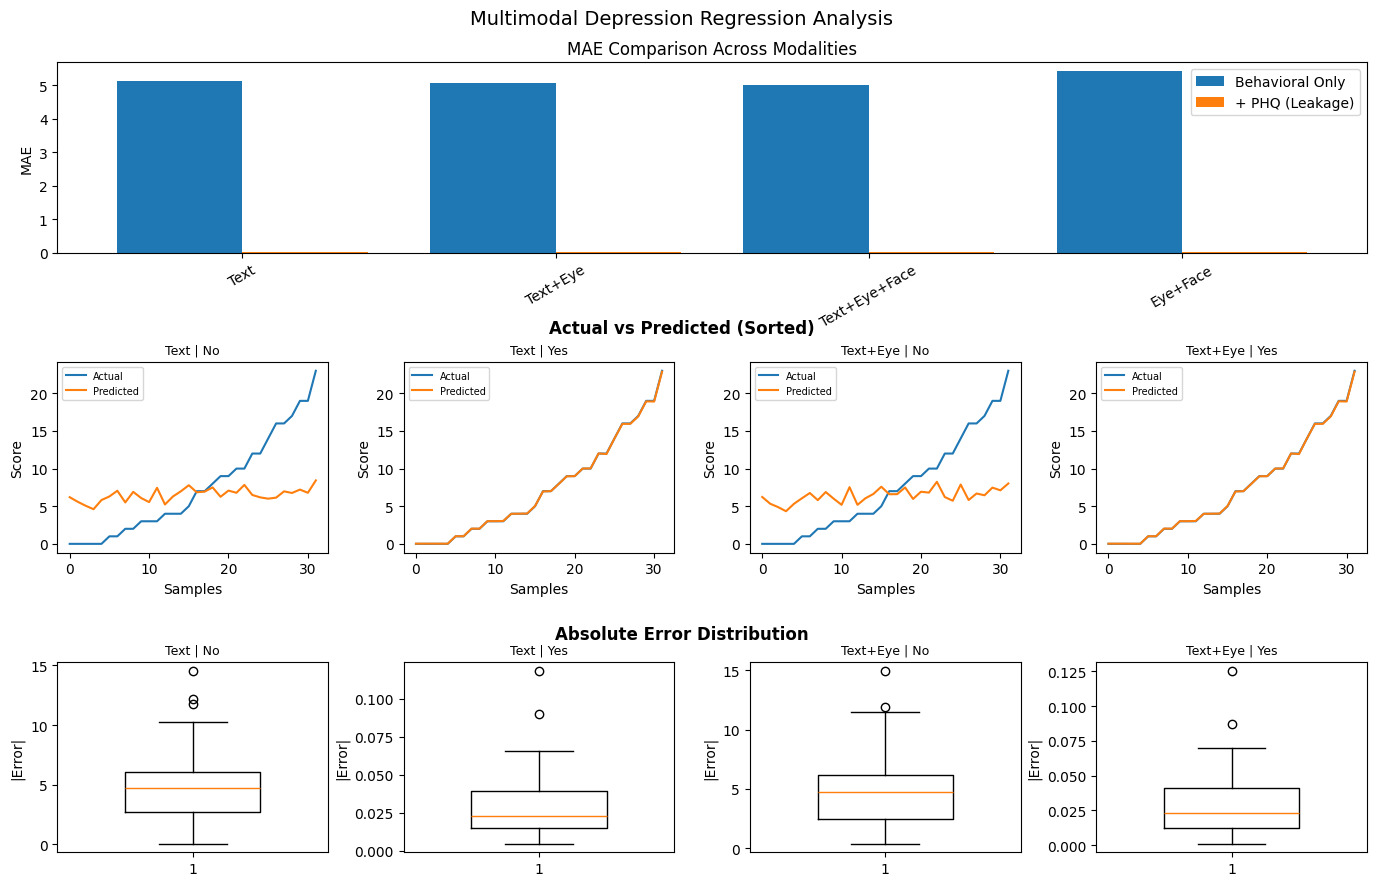

In [ ]:
run_experiments("master_dataset.csv", "train_split_Depression_AVEC2017.csv", "dev_split_Depression_AVEC2017.csv")

### Transformer-Based Depression Detection: Text Data Preparation and Dataset Construction

In [ ]:
"""
==============================================================
Transformer-Based Depression Detection (Text Modality)
--------------------------------------------------------------

This notebook prepares the textual dataset for training a
Transformer-based depression classifier (e.g., BERT, RoBERTa).

Goal
----
Construct clean Train and Test splits using:
    • Participant transcripts (text)

Pipeline
--------
1. Load master feature dataset (contains transcript text)
2. Load official AVEC 2017 train/test splits
3. Merge text with clinical labels using participant_id
4. Output clean DataFrames:
       train_data
       test_data

These datasets will later be tokenized and fed into a
Transformer architecture for fine-tuning.

Output Format
-------------
train_data / test_data columns:
    participant_id : unique subject ID
    text           : full transcript text
    is_depressed   : binary label (0 = healthy, 1 = depressed)

This ensures:
    ✓ reproducibility
    ✓ no data leakage
    ✓ official split consistency

==============================================================
"""

import pandas as pd


# ==========================================================
# LOAD DATASETS
# ==========================================================

# Master dataset (contains extracted features + full transcript text)
master_data = pd.read_csv("master_dataset.csv")

# Official AVEC training split
train_split = (
    pd.read_csv("train_split_Depression_AVEC2017.csv")
      .rename(columns={"Participant_ID": "participant_id"})
)

# Official AVEC testing split
test_split = (
    pd.read_csv("dev_split_Depression_AVEC2017.csv")
      .rename(columns={"Participant_ID": "participant_id"})
)


# ==========================================================
# MERGE TEXT WITH LABELS
# ==========================================================

# Keep only necessary columns for Transformer (text + label)
text_df = master_data[["participant_id", "text"]]

# Train set
train_data = (
    pd.merge(text_df,
             train_split[["participant_id", "PHQ8_Binary"]],
             on="participant_id",
             how="inner")
      .rename(columns={"PHQ8_Binary": "is_depressed"})
)

# Test set
test_data = (
    pd.merge(text_df,
             test_split[["participant_id", "PHQ8_Binary"]],
             on="participant_id",
             how="inner")
      .rename(columns={"PHQ8_Binary": "is_depressed"})
)


# ==========================================================
# QUICK CHECK
# ==========================================================

print("Train shape:", train_data.shape)
print("Test shape :", test_data.shape)

train_data.head()

Train shape: (107, 3)
Test shape : (35, 3)


,participant_id,text,is_depressed
0,303,okay how 'bout yourself here in california yea...,0
1,304,i'm doing good um from los angeles california ...,0
2,305,i'm doing alright uh originally i'm from calif...,0
3,310,yes it's okay <laughter> fine <laughter> i liv...,0
4,312,yes fine how about you here yes the weather we...,0


In [ ]:
train_data.count()

,0
participant_id,107
text,107
is_depressed,107


In [ ]:
master_data.eye_contact_rate

,eye_contact_rate
0,0.991182
1,0.965755
2,0.992998
3,0.905803
4,0.987853
...,...
182,0.853667
183,0.994986
184,0.996770
185,0.951987


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from torch.cuda.amp import GradScaler, autocast
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import warnings
import os
import random

seed = 47

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

# 2. PyTorch CPU and CUDA seeds
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # For multi-GPU/all-CUDA devices

# 3. Force CUDNN to be deterministic (The "Secret Sauce")
# This tells the A100 to use the same math path every time
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 4. For latest PyTorch versions, ensure deterministic algorithms
torch.use_deterministic_algorithms(True, warn_only=True)


# Suppress warnings
warnings.filterwarnings("ignore")

class DepressionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=256):
        self.texts = dataframe['text'].fillna("").tolist()
        self.labels = dataframe['is_depressed'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(int(self.labels[idx]), dtype=torch.long)
        }

class SimpleDepressionClassifier:
    def __init__(self, model_name="bert-base-uncased"):
        print(f"Using pretrained Model: {model_name}")
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(self.device)

        print("Freezing BERT base layers...")
        # Unfreeze the classifier and the last layer of the ALBERT encoder
        for name, param in self.model.named_parameters():
            if "classifier" in name or "albert_layer_groups" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # --- VISUALIZATION PREP: HISTORY TRACKING ---
        self.history = {
            'train_loss': [], 'test_loss': [],
            'train_f1': [], 'test_f1': [],
            'best_epoch_probs': [], 'best_epoch_labels': []
        }


    def create_dataloaders(self, train_data, test_data, batch_size=32):
        train_loader = DataLoader(
            DepressionDataset(train_data, self.tokenizer),
            batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
        )
        test_loader = DataLoader(
            DepressionDataset(test_data, self.tokenizer),
            batch_size=batch_size*2, shuffle=False, num_workers=4, pin_memory=True
        )
        return train_loader, test_loader

    def train(self, train_loader, test_loader, epochs=5):
        # Only optimize the parameters that are NOT frozen
        optimizer = AdamW(filter(lambda p: p.requires_grad, self.model.parameters()),
                  lr=3e-5,
                  weight_decay=0.1)
        total_steps = len(train_loader) * epochs
        scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        # Increased weight for class 1 to 4.0 to further combat False Negatives
        weights = torch.tensor([1.0, 3]).to(self.device)
        criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

        # 2. Use a more sensitive threshold
        threshold = 0.54

        scaler = GradScaler()
        best_f1 = 0.0  # Track the best F1 score

        for epoch in range(epochs):
            # --- TRAIN PHASE ---
            self.model.train()
            train_loss, train_preds, train_labels = 0, [], []
            for batch in train_loader:
                optimizer.zero_grad(set_to_none=True)
                ids, mask, labels = batch['input_ids'].to(self.device), batch['attention_mask'].to(self.device), batch['labels'].to(self.device)

                with autocast():
                    outputs = self.model(input_ids=ids, attention_mask=mask)
                    loss = criterion(outputs.logits, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()

                train_loss += loss.item()

                train_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
                train_labels.extend(labels.cpu().numpy())

            # --- TEST PHASE ---
            self.model.eval()
            test_loss, test_preds, test_labels, test_probs = 0, [], [], []
            with torch.no_grad():
                for batch in test_loader:
                    ids, mask, labels = batch['input_ids'].to(self.device), batch['attention_mask'].to(self.device), batch['labels'].to(self.device)
                    outputs = self.model(input_ids=ids, attention_mask=mask)
                    loss = criterion(outputs.logits, labels)
                    test_loss += loss.item()


                    # ADD THIS LINE to capture the probabilities:
                    probs = torch.softmax(outputs.logits, dim=1)[:, 1]
                    test_probs.extend(probs.cpu().numpy()) # <--- CRITICAL ADDITION

                    test_preds.extend((probs > threshold).long().cpu().numpy())
                    test_labels.extend(labels.cpu().numpy())
                    # test_preds.extend((torch.softmax(outputs.logits, dim=1)[:, 1] > threshold).long().cpu().numpy())
                    # test_labels.extend(labels.cpu().numpy())

            # Metrics Calculation
            avg_train_loss = train_loss / len(train_loader)
            avg_test_loss = test_loss / len(test_loader)
            tr_acc = accuracy_score(train_labels, train_preds)
            tr_f1 = f1_score(train_labels, train_preds)
            ts_acc = accuracy_score(test_labels, test_preds)
            ts_f1 = f1_score(test_labels, test_preds)

            # --- VISUALIZATION PREP: UPDATE HISTORY ---
            self.history['train_loss'].append(avg_train_loss)
            self.history['test_loss'].append(avg_test_loss)
            self.history['train_f1'].append(tr_f1)
            self.history['test_f1'].append(ts_f1)

            # Save the best model based on Test F1
            status_msg = ""
            if ts_f1 > best_f1:
                best_f1 = ts_f1
                torch.save(self.model.state_dict(), 'best_model.pth')
                # Save best epoch data for final matrix/distribution visualization
                self.history['best_epoch_probs'] = test_probs
                self.history['best_epoch_labels'] = test_labels
                status_msg = " -> [BEST SAVED]"

            # One-line consolidated output
            print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss/len(train_loader):.4f} Train Acc: {tr_acc:.2%} Train F1: {tr_f1:.4f} | Test Loss: {test_loss/len(test_loader):.4f} Test Acc: {ts_acc:.2%} Test F1: {ts_f1:.4f}{status_msg}")

        # Load the best weights before final analysis
        if os.path.exists('best_model.pth'):
            self.model.load_state_dict(torch.load('best_model.pth'))

        # Final Analysis (Using the best weights loaded above)
        final_cm = confusion_matrix(test_labels, test_preds)
        print("\n" + "="*30)
        print("FINAL BEST TEST CONFUSION MATRIX (Text)")
        print("="*30)
        print(f"True Negatives (Not Depressed): {final_cm[0][0]} | False Positives: {final_cm[0][1]}")
        print(f"False Negatives: {final_cm[1][0]} | True Positives (Depressed): {final_cm[1][1]}")
        print("="*30)

        return ts_acc, final_cm

In [ ]:
# Initialize classifier
classifier = SimpleDepressionClassifier(model_name="albert-base-v2")

# Create dataloaders
train_loader, test_loader = classifier.create_dataloaders(train_data, test_data)

# Train for 5 epochs
final_acc, final_cm = classifier.train(train_loader, test_loader, epochs=10)

# Print final results
print(f"\nTraining completed!")
print(f"Model saved: simple_depression_model.pth")

Using pretrained Model: albert-base-v2


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/25 [00:00<?, ?it/s]

AlbertForSequenceClassification LOAD REPORT from: albert-base-v2
Key                          | Status     | 
-----------------------------+------------+-
predictions.dense.weight     | UNEXPECTED | 
predictions.decoder.bias     | UNEXPECTED | 
predictions.bias             | UNEXPECTED | 
predictions.LayerNorm.weight | UNEXPECTED | 
predictions.dense.bias       | UNEXPECTED | 
predictions.LayerNorm.bias   | UNEXPECTED | 
classifier.weight            | MISSING    | 
classifier.bias              | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Freezing BERT base layers...
Epoch 01 | Train Loss: 0.7746 Train Acc: 41.12% Train F1: 0.3883 | Test Loss: 0.7257 Test Acc: 65.71% Test F1: 0.0000
Epoch 02 | Train Loss: 0.7223 Train Acc: 39.25% Train F1: 0.4144 | Test Loss: 0.6798 Test Acc: 37.14% Test F1: 0.5217 -> [BEST SAVED]
Epoch 03 | Train Loss: 0.6784 Train Acc: 55.14% Train F1: 0.4894 | Test Loss: 0.7370 Test Acc: 65.71% Test F1: 0.1429
Epoch 04 | Train Loss: 0.6031 Train Acc: 77.57% Train F1: 0.6842 | Test Loss: 0.6529 Test Acc: 68.57% Test F1: 0.6207 -> [BEST SAVED]
Epoch 05 | Train Loss: 0.5766 Train Acc: 72.90% Train F1: 0.6588 | Test Loss: 0.6645 Test Acc: 62.86% Test F1: 0.5517
Epoch 06 | Train Loss: 0.5230 Train Acc: 74.77% Train F1: 0.6747 | Test Loss: 0.7851 Test Acc: 65.71% Test F1: 0.3333
Epoch 07 | Train Loss: 0.4799 Train Acc: 80.37% Train F1: 0.7273 | Test Loss: 0.6839 Test Acc: 74.29% Test F1: 0.5714
Epoch 08 | Train Loss: 0.4378 Train Acc: 88.79% Train F1: 0.8286 | Test Loss: 0.6913 Test Acc: 77.14% Test F1: 0.

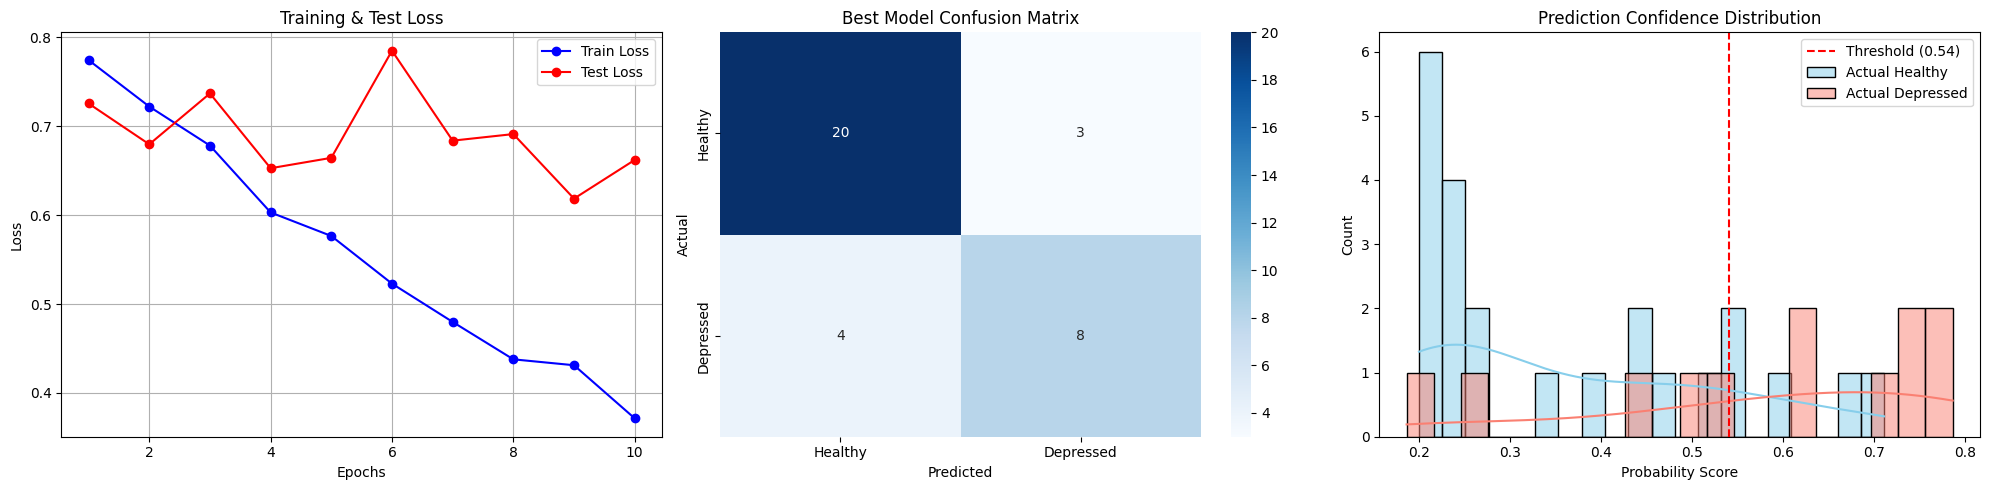

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_results(classifier, threshold=0.54):
    h = classifier.history
    epochs = range(1, len(h['train_loss']) + 1)

    # Set up the figure
    plt.figure(figsize=(20, 5))

    # 1. Learning Curves (Loss)
    plt.subplot(1, 3, 1)
    plt.plot(epochs, h['train_loss'], 'b-o', label='Train Loss')
    plt.plot(epochs, h['test_loss'], 'r-o', label='Test Loss')
    plt.title('Training & Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Confusion Matrix Heatmap
    plt.subplot(1, 3, 2)
    # Re-calculate predictions from the best saved probabilities
    best_preds = [1 if p > threshold else 0 for p in h['best_epoch_probs']]
    cm = confusion_matrix(h['best_epoch_labels'], best_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Healthy', 'Depressed'],
                yticklabels=['Healthy', 'Depressed'])
    plt.title('Best Model Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # 3. Probability Distribution Histogram
    plt.subplot(1, 3, 3)
    probs = np.array(h['best_epoch_probs'])
    labels = np.array(h['best_epoch_labels'])

    sns.histplot(probs[labels == 0], color="skyblue", label="Actual Healthy", kde=True, bins=20)
    sns.histplot(probs[labels == 1], color="salmon", label="Actual Depressed", kde=True, bins=20)
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
    plt.title('Prediction Confidence Distribution')
    plt.xlabel('Probability Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Usage after training:
plot_training_results(classifier, threshold=0.54)

In [ ]:
class DepressionInference:
    def __init__(self, model_path='best_model.pth', model_name="albert-base-v2"):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Load architecture
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

        # Load saved weights
        if os.path.exists(model_path):
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))
            print(f"Successfully loaded weights from {model_path}")
        else:
            raise FileNotFoundError("Weight file not found! Please run training first.")

        self.model.to(self.device)
        self.model.eval()

    def predict(self, text, threshold=0.54):
        # Preprocess text
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=256
        ).to(self.device)

        with torch.no_grad():
            outputs = self.model(**inputs)
            # Convert raw logits to probability for the 'Depressed' class
            probs = torch.softmax(outputs.logits, dim=1)
            depression_prob = probs[0][1].item()

        status = "DEPRESSED" if depression_prob > threshold else "HEALTHY"
        confidence = depression_prob if status == "DEPRESSED" else (1 - depression_prob)

        return {
            "prediction": status,
            "probability": round(depression_prob, 4),
            "confidence": f"{round(confidence * 100, 2)}%"
        }

# --- Usage Example ---
engine = DepressionInference()
result = engine.predict("I feel so exhausted and lost lately, nothing seems to matter.")
print(result)

Loading weights:   0%|          | 0/25 [00:00<?, ?it/s]

AlbertForSequenceClassification LOAD REPORT from: albert-base-v2
Key                          | Status     | 
-----------------------------+------------+-
predictions.dense.weight     | UNEXPECTED | 
predictions.decoder.bias     | UNEXPECTED | 
predictions.bias             | UNEXPECTED | 
predictions.LayerNorm.weight | UNEXPECTED | 
predictions.dense.bias       | UNEXPECTED | 
predictions.LayerNorm.bias   | UNEXPECTED | 
classifier.weight            | MISSING    | 
classifier.bias              | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Successfully loaded weights from best_model.pth
{'prediction': 'DEPRESSED', 'probability': 0.6738, 'confidence': '67.38%'}


In [ ]:
engine.predict("I feel so empty and I don't want to get out of bed anymore.")

{'prediction': 'DEPRESSED', 'probability': 0.546, 'confidence': '54.6%'}

In [ ]:
engine.predict("I had a busy day at work but I am looking forward to the weekend!")

{'prediction': 'HEALTHY', 'probability': 0.5171, 'confidence': '48.29%'}

In [ ]:
engine.predict("Everything feels like a gray fog and I can't find joy in my hobbies.")

{'prediction': 'DEPRESSED', 'probability': 0.5669, 'confidence': '56.69%'}

In [ ]:
engine.predict("I'm a bit tired today because I stayed up late watching a movie.")

{'prediction': 'HEALTHY', 'probability': 0.533, 'confidence': '46.7%'}

In [ ]:
"""
==============================================================
Transformer-Based Depression Detection (Text Modality)
--------------------------------------------------------------

This notebook prepares the textual dataset for training a
Transformer-based depression classifier (e.g., BERT, RoBERTa).

Goal
----
Construct clean Train and Test splits using:
    • Participant transcripts (text)

Pipeline
--------
1. Load master feature dataset (contains transcript text)
2. Load official AVEC 2017 train/test splits
3. Merge text with clinical labels using participant_id
4. Output clean DataFrames:
       train_data
       test_data

These datasets will later be tokenized and fed into a
Transformer architecture for fine-tuning.

Output Format
-------------
train_data / test_data columns:
    participant_id : unique subject ID
    text           : full transcript text
    is_depressed   : binary label (0 = healthy, 1 = depressed)

This ensures:
    ✓ reproducibility
    ✓ no data leakage
    ✓ official split consistency

==============================================================
"""

import pandas as pd


# ==========================================================
# LOAD DATASETS
# ==========================================================

# Master dataset (contains extracted features + full transcript text)
master_data = pd.read_csv("master_dataset.csv")

# Official AVEC training split
train_split = (
    pd.read_csv("train_split_Depression_AVEC2017.csv")
      .rename(columns={"Participant_ID": "participant_id"})
)

# Official AVEC testing split
test_split = (
    pd.read_csv("dev_split_Depression_AVEC2017.csv")
      .rename(columns={"Participant_ID": "participant_id"})
)


# ==========================================================
# MERGE TEXT WITH LABELS
# ==========================================================

# Keep only necessary columns for Transformer (text + label)
text_df = master_data[["participant_id", "text","avg_gaze_downward","eye_contact_rate" ]]

# Train set
train_data = (
    pd.merge(text_df,
             train_split[["participant_id", "PHQ8_Binary"]],
             on="participant_id",
             how="inner")
      .rename(columns={"PHQ8_Binary": "is_depressed"})
)

# Test set
test_data = (
    pd.merge(text_df,
             test_split[["participant_id", "PHQ8_Binary"]],
             on="participant_id",
             how="inner")
      .rename(columns={"PHQ8_Binary": "is_depressed"})
)


# ==========================================================
# QUICK CHECK
# ==========================================================

print("Train shape:", train_data.shape)
print("Test shape :", test_data.shape)

train_data.head()

Train shape: (107, 5)
Test shape : (35, 5)


,participant_id,text,avg_gaze_downward,eye_contact_rate,is_depressed
0,303,okay how 'bout yourself here in california yea...,0.097532,0.992998,0
1,304,i'm doing good um from los angeles california ...,0.211096,0.905803,0
2,305,i'm doing alright uh originally i'm from calif...,0.269754,0.987853,0
3,310,yes it's okay <laughter> fine <laughter> i liv...,0.237467,0.964973,0
4,312,yes fine how about you here yes the weather we...,0.308864,0.983587,0


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel, get_scheduler
from torch.cuda.amp import GradScaler, autocast
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import warnings
import os
import random

seed = 47
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True, warn_only=True)
warnings.filterwarnings("ignore")

# 1. UPDATED DATASET (Includes Gaze Columns)
class DepressionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=256):
        self.df = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        encoding = self.tokenizer(
            str(row['text']),
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Capture the two numerical features
        gaze_feats = torch.tensor([
            float(row['avg_gaze_downward']),
            float(row['eye_contact_rate'])
        ], dtype=torch.float)

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'gaze_features': gaze_feats,
            'labels': torch.tensor(int(row['is_depressed']), dtype=torch.long)
        }

# 2. HYBRID MODEL (Glues ALBERT/BERT to Gaze Features)
class MultimodalClassifier(nn.Module):
    def __init__(self, model_name):
        super(MultimodalClassifier, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        # 768 (Text features) + 2 (Gaze features)
        self.classifier = nn.Linear(768 + 2, 2)

    def forward(self, input_ids, attention_mask, gaze_features):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        combined = torch.cat((pooled_output, gaze_features), dim=1)
        return self.classifier(self.dropout(combined))

# 3. MAIN CLASSIFIER (Same structure as requested)
class MultiModalDepressionClassifier:
    def __init__(self, model_name="albert-base-v2"):
        print(f"Using pretrained Model: {model_name}")
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        # Use our Hybrid Model inside
        self.model = MultimodalClassifier(model_name).to(self.device)

        print("Freezing base layers...")
        for name, param in self.model.named_parameters():
            if "classifier" in name or "albert_layer_groups" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        self.history = {
            'train_loss': [], 'test_loss': [],
            'train_f1': [], 'test_f1': [],
            'best_epoch_probs': [], 'best_epoch_labels': []
        }

    def create_dataloaders(self, train_data, test_data, batch_size=32):
        train_loader = DataLoader(
            DepressionDataset(train_data, self.tokenizer),
            batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
        )
        test_loader = DataLoader(
            DepressionDataset(test_data, self.tokenizer),
            batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True
        )
        return train_loader, test_loader

    def train(self, train_loader, test_loader, epochs=5):
        optimizer = AdamW(filter(lambda p: p.requires_grad, self.model.parameters()), lr=2e-5, weight_decay=0.1)
        total_steps = len(train_loader) * epochs
        scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        weights = torch.tensor([1.0, 2.5]).to(self.device)
        criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)
        threshold = 0.54
        scaler = GradScaler()
        best_f1 = 0.0

        for epoch in range(epochs):
            # --- TRAIN PHASE ---
            self.model.train()
            train_loss, train_preds, train_labels = 0, [], []
            for batch in train_loader:
                optimizer.zero_grad(set_to_none=True)
                ids, mask = batch['input_ids'].to(self.device), batch['attention_mask'].to(self.device)
                gaze, labels = batch['gaze_features'].to(self.device), batch['labels'].to(self.device)

                with autocast():
                    logits = self.model(ids, mask, gaze)
                    loss = criterion(logits, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()

                train_loss += loss.item()
                train_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
                train_labels.extend(labels.cpu().numpy())

            # --- TEST PHASE ---
            self.model.eval()
            test_loss, test_preds, test_labels, test_probs = 0, [], [], []
            with torch.no_grad():
                for batch in test_loader:
                    ids, mask = batch['input_ids'].to(self.device), batch['attention_mask'].to(self.device)
                    gaze, labels = batch['gaze_features'].to(self.device), batch['labels'].to(self.device)

                    logits = self.model(ids, mask, gaze)
                    loss = criterion(logits, labels)
                    test_loss += loss.item()

                    probs = torch.softmax(logits, dim=1)[:, 1]
                    test_probs.extend(probs.cpu().numpy())
                    test_preds.extend((probs > threshold).long().cpu().numpy())
                    test_labels.extend(labels.cpu().numpy())

            # Metrics Calculation
            avg_train_loss, avg_test_loss = train_loss/len(train_loader), test_loss/len(test_loader)
            tr_acc, tr_f1 = accuracy_score(train_labels, train_preds), f1_score(train_labels, train_preds)
            ts_acc, ts_f1 = accuracy_score(test_labels, test_preds), f1_score(test_labels, test_preds)

            self.history['train_loss'].append(avg_train_loss)
            self.history['test_loss'].append(avg_test_loss)
            self.history['train_f1'].append(tr_f1)
            self.history['test_f1'].append(ts_f1)

            status_msg = ""
            if ts_f1 > best_f1:
                best_f1 = ts_f1
                torch.save(self.model.state_dict(), 'best_model.pth')
                self.history['best_epoch_probs'] = test_probs
                self.history['best_epoch_labels'] = test_labels
                status_msg = " -> [BEST SAVED]"
                best_test_labels, best_test_preds = test_labels, test_preds


            print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} Acc: {tr_acc:.2%} F1: {tr_f1:.4f} | Test Loss: {avg_test_loss:.4f} Acc: {ts_acc:.2%} F1: {ts_f1:.4f}{status_msg}")

        return ts_acc, confusion_matrix(best_test_labels, best_test_preds)

In [ ]:
multi_classifier = MultiModalDepressionClassifier(model_name="albert-base-v2")

train_loader, test_loader = multi_classifier.create_dataloaders(train_data, test_data)
multi_classifier.train(train_loader, test_loader, epochs=10)

Using pretrained Model: albert-base-v2


Loading weights:   0%|          | 0/25 [00:00<?, ?it/s]

AlbertModel LOAD REPORT from: albert-base-v2
Key                          | Status     |  | 
-----------------------------+------------+--+-
predictions.dense.weight     | UNEXPECTED |  | 
predictions.decoder.bias     | UNEXPECTED |  | 
predictions.bias             | UNEXPECTED |  | 
predictions.LayerNorm.weight | UNEXPECTED |  | 
predictions.dense.bias       | UNEXPECTED |  | 
predictions.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Freezing base layers...
Epoch 01 | Train Loss: 0.7762 Acc: 37.38% F1: 0.3093 | Test Loss: 0.7280 Acc: 60.00% F1: 0.1250 -> [BEST SAVED]
Epoch 02 | Train Loss: 0.7181 Acc: 68.22% F1: 0.4333 | Test Loss: 0.6889 Acc: 65.71% F1: 0.0000
Epoch 03 | Train Loss: 0.6735 Acc: 71.96% F1: 0.3478 | Test Loss: 0.6883 Acc: 60.00% F1: 0.0000
Epoch 04 | Train Loss: 0.6668 Acc: 76.64% F1: 0.5763 | Test Loss: 0.7073 Acc: 54.29% F1: 0.1111
Epoch 05 | Train Loss: 0.6400 Acc: 59.81% F1: 0.5474 | Test Loss: 0.7087 Acc: 60.00% F1: 0.3636 -> [BEST SAVED]
Epoch 06 | Train Loss: 0.5925 Acc: 75.70% F1: 0.6750 | Test Loss: 0.6793 Acc: 71.43% F1: 0.4444 -> [BEST SAVED]
Epoch 07 | Train Loss: 0.5898 Acc: 82.24% F1: 0.7164 | Test Loss: 0.6589 Acc: 68.57% F1: 0.3529
Epoch 08 | Train Loss: 0.5471 Acc: 85.05% F1: 0.7778 | Test Loss: 0.6697 Acc: 60.00% F1: 0.3636
Epoch 09 | Train Loss: 0.5084 Acc: 86.92% F1: 0.7941 | Test Loss: 0.6499 Acc: 62.86% F1: 0.3158
Epoch 10 | Train Loss: 0.4832 Acc: 88.79% F1: 0.8286 | Test Loss

(0.6857142857142857,
 array([[21,  2],
        [ 8,  4]]))

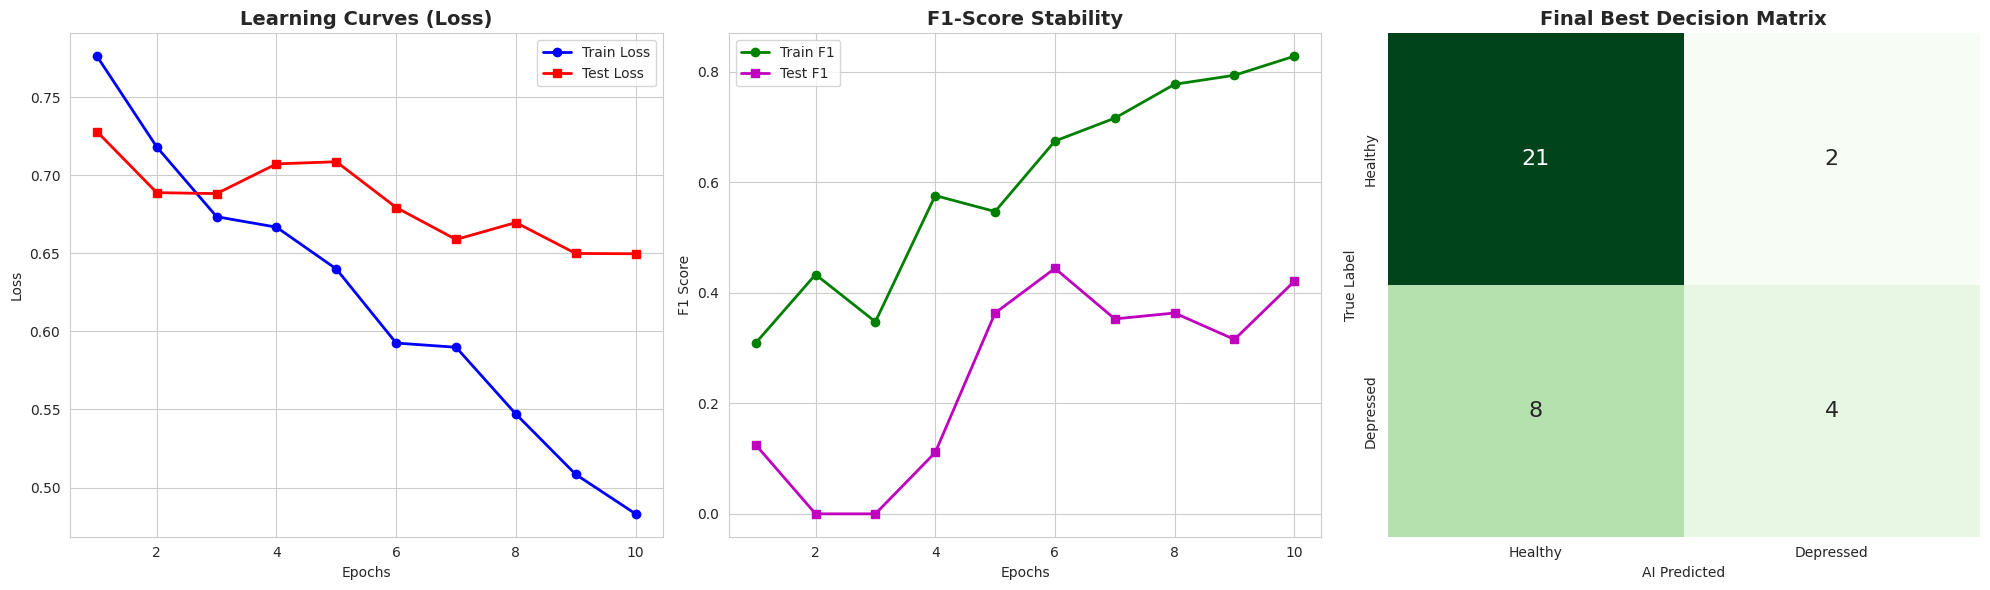

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_multimodal_performance(classifier):
    h = classifier.history
    epochs = range(1, len(h['train_loss']) + 1)

    # Set the aesthetic style
    sns.set_style("whitegrid")
    plt.figure(figsize=(20, 6))

    # 1. LOSS CURVE: Training vs Validation
    plt.subplot(1, 3, 1)
    plt.plot(epochs, h['train_loss'], 'b-o', label='Train Loss', linewidth=2)
    plt.plot(epochs, h['test_loss'], 'r-s', label='Test Loss', linewidth=2)
    plt.title('Learning Curves (Loss)', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 2. F1-SCORE: Model Reliability over time
    plt.subplot(1, 3, 2)
    plt.plot(epochs, h['train_f1'], 'g-o', label='Train F1', linewidth=2)
    plt.plot(epochs, h['test_f1'], 'm-s', label='Test F1', linewidth=2)
    plt.title('F1-Score Stability', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # 3. DYNAMIC CONFUSION MATRIX
    # We calculate this from the best saved epoch in your history
    plt.subplot(1, 3, 3)

    # Using the threshold 0.54 as defined in your train method
    threshold = 0.54
    best_preds = [1 if p > threshold else 0 for p in h['best_epoch_probs']]
    cm = confusion_matrix(h['best_epoch_labels'], best_preds)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=['Healthy', 'Depressed'],
                yticklabels=['Healthy', 'Depressed'],
                annot_kws={"size": 16})
    plt.title('Final Best Decision Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('AI Predicted')
    plt.ylabel('True Label')

    plt.tight_layout()
    plt.show()

# Execute using your active object
plot_multimodal_performance(multi_classifier)